imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

Read the csv

In [2]:
df = pd.read_csv('data/Combined_Less.csv', low_memory = False)

Drop the null values from the TotCount column

In [3]:
df_filtered = df.dropna(subset=['TotCount'])
#df_filtered.head()

Output the total count of each Common_Name. This is used to determine which fish we want to analyze

In [4]:
common_name_counts = df_filtered['Common_Name'].value_counts()
tot_count_per_name = df_filtered.groupby('Common_Name')['TotCount'].sum()
for common_name in common_name_counts.index:
    count = common_name_counts[common_name]
    tot_count = tot_count_per_name[common_name]
    #print(f"{common_name}: {count} rows, Total TotCount: {tot_count}")

We ended up choosing a Bluntnose Minnow. Since this is a baitfish (prey), we include a total count of the below list of predatory fish (I provided ChatGPT with a list of the common names, and it output the most likely fish to eat the Broadnose minnow. We add this count as a new column called pred_count

In [5]:
Predators = ['Rock Bass',
'Smallmouth Bass',
'Largemouth Bass',
'Northern Pike',
'Flathead Catfish',
'Yellow Perch',
'Pumpkinseed Sunfish',
'Black Crappie',
'Orangespotted Sunfish',
'Redear Sunfish',
'Spotted Bass',
'Longnose Gar',
'Bowfin',
'Channel Catfish',
'Freshwater Drum',
'Walleye',
'Sauger',
'Muskellunge',
'Brown Trout',
'Rainbow Trout',
'Brook Trout',
'Chain Pickerel',
'Striped Bass',
'Blue Sucker',
'Shortnose Gar']
predatory_fish_df = df_filtered[df_filtered['Common_Name'].isin(Predators)]
pred_count_df = predatory_fish_df.groupby('Station_Date')['TotCount'].sum().reset_index()
pred_count_df.rename(columns={'TotCount': 'pred_count'}, inplace=True)
fish_df = df_filtered.merge(pred_count_df, on='Station_Date', how='left')
fish_df['pred_count'].fillna(0, inplace=True)

In [6]:
#fish_df.head()

Determine our target fish and only retain rows with this common name. We chose this fish because it has the most records available.

In [7]:
selected_fish = 'Bluntnose Minnow'
fish_df = fish_df[fish_df['Common_Name'] == selected_fish].copy()
#fish_df.head()

Determine if any columns are constants meaning the same value is present in all columns. These columns will be dropped from the df

In [8]:
constant_columns = [col for col in fish_df.columns if fish_df[col].nunique() <= 1]
print("Constant Columns:", constant_columns)

Constant Columns: ['species', 'state', 'Common_Name', 'Dataset', 'ECOREGL3', 'BigHUC', 'FE', 'MN', 'TP', 'do', 'Temp', 'GENUS', 'NUMSPEC', 'NSBENT_INV', 'NSBENT_INV_NONTOL', 'NSINTOL', 'PINTOL', 'PBENT_INV', 'PBENT_INV_NONTOL', 'abent_inv', 'abent_inv_nontol', 'aintol', 'ns_DarScuMad', 'ab_DarScuMad', 'p_DarScuMad', 'FOR_TOT', 'hardness', 'Fecal_Coliform', 'xembed', 'pct_safn', 'al', 'Se', 'Cadmium', 'Calcium']


drop these columns as well as the SUMCOUNT column because it is the exact same as the TotCount which we will use for our X variable. For now, we only want to work with the numerical values.

In [9]:
fish_df = fish_df.drop(columns=constant_columns)
fish_df = fish_df.drop(columns=['SUMCOUNT'])
numerical_df = fish_df.select_dtypes(include=[np.number])

Determine the percentage of null values per column and output that information

In [10]:
null_percentage = numerical_df.isnull().mean() * 100
for column, percentage in null_percentage.items():
    print(f"{column}: {percentage:.2f}%")

YEAR: 0.00%
month: 0.00%
LAT_DD: 0.00%
LON_DD: 0.00%
HUC: 0.00%
PHSTVL: 0.00%
COND: 0.00%
CA: 4.25%
SO4: 11.02%
NO3: 4.09%
CL: 4.09%
alk: 11.18%
rbpscore: 55.75%
ABUND: 0.00%
WS_AREA: 0.00%
LWSKM2: 0.00%
lcond: 0.00%
SO4HCO3: 11.18%
ratio: 11.18%
TotCount: 0.00%
RA: 0.00%
VISIT_NO: 0.00%
num: 0.00%
mg: 4.88%
na: 4.25%
k: 4.25%
hco3: 11.18%
tn: 4.09%
pred_count: 0.00%


drop the rbpscore column as it has a large number of missing values

In [11]:
numerical_df = numerical_df.drop(columns = ['rbpscore'])

determine the percentage of values per column that show outliers using the IQR technique. 

In [12]:
outlier_info = {}
for column in numerical_df.select_dtypes(include=[np.number]).columns:
    Q1 = numerical_df[column].quantile(0.25)
    Q3 = numerical_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = numerical_df[(numerical_df[column] < lower_bound) | (numerical_df[column] > upper_bound)][column]
    outlier_percentage = (len(outliers) / len(df)) * 100
    outlier_info[column] = outlier_percentage

Print out each null percentage and the outlier percentage for each column

In [13]:
for column in numerical_df.columns:
    if column in outlier_info:
        print(f"{column}: Null Percentage = {null_percentage[column]:.2f}%, Outlier Percentage = {outlier_info[column]:.2f}%")
    else:
        print(f"{column}: Null Percentage = {null_percentage[column]:.2f}%")

YEAR: Null Percentage = 0.00%, Outlier Percentage = 0.04%
month: Null Percentage = 0.00%, Outlier Percentage = 0.13%
LAT_DD: Null Percentage = 0.00%, Outlier Percentage = 0.00%
LON_DD: Null Percentage = 0.00%, Outlier Percentage = 0.00%
HUC: Null Percentage = 0.00%, Outlier Percentage = 0.00%
PHSTVL: Null Percentage = 0.00%, Outlier Percentage = 0.03%
COND: Null Percentage = 0.00%, Outlier Percentage = 0.12%
CA: Null Percentage = 4.25%, Outlier Percentage = 0.10%
SO4: Null Percentage = 11.02%, Outlier Percentage = 0.14%
NO3: Null Percentage = 4.09%, Outlier Percentage = 0.14%
CL: Null Percentage = 4.09%, Outlier Percentage = 0.10%
alk: Null Percentage = 11.18%, Outlier Percentage = 0.00%
ABUND: Null Percentage = 0.00%, Outlier Percentage = 0.12%
WS_AREA: Null Percentage = 0.00%, Outlier Percentage = 0.21%
LWSKM2: Null Percentage = 0.00%, Outlier Percentage = 0.02%
lcond: Null Percentage = 0.00%, Outlier Percentage = 0.02%
SO4HCO3: Null Percentage = 11.18%, Outlier Percentage = 0.12%
ra

Since we don't have any columns with a high percentage of outliers, we can impute the missing values by the mean rather than the median

In [14]:
numerical_df = numerical_df.fillna(numerical_df.mean())

Let's see the distribution of TotCount. It's right-skewed which is to be expected. In ecological datasets, it's common to see the distribution skewed to the right. This is because if a population is smaller than a certain number, it's unlikely that the population lived and reproduced enough to be counted in our dataset. Basically, the fewer members of a species exists in a given area, the more likely that they will be driven to extinction in that area either due to natural or man-made reasons.

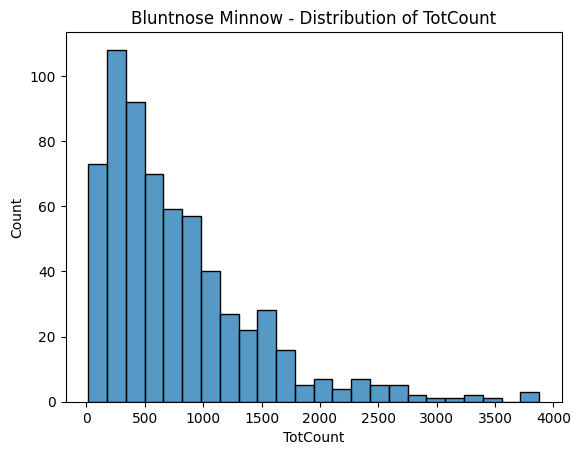

In [15]:
sns.histplot(numerical_df['TotCount'])
plt.title(f'{selected_fish} - Distribution of TotCount')
plt.show()

Let's make a correlation matrix. When considering TotCount, a few correlations stick out. Our created pred_count column has a high positive impact. This is to be expected as the greater number of predatory fish a given area can hold indicates a healthier overall balance. You may notice ABUND is highly correlative as well. We'll handle this later.

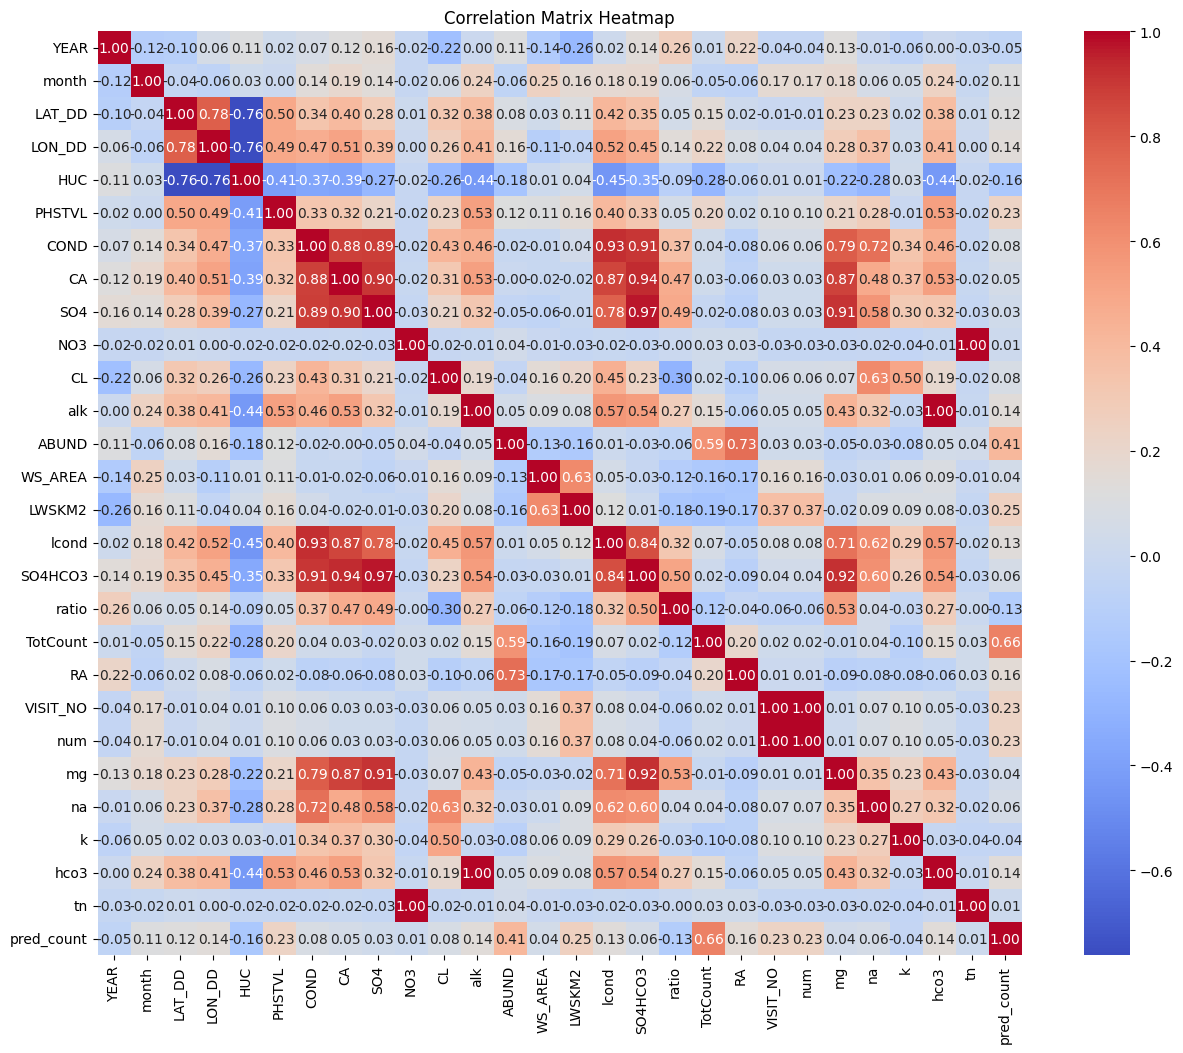

In [16]:
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

print the actual correlation values for TotCount column

In [17]:
totcount_corr = correlation_matrix['TotCount'].sort_values(ascending=False)
#print(totcount_corr)

Let's set up our linear regression to begin with. We start by splitting the dataset into training and testing sections, scaling them to an appropriate range, and initializing our model

In [18]:
X = numerical_df.drop(columns=['TotCount'])
y = numerical_df['TotCount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = LinearRegression()

let's train the model

In [19]:
model.fit(X_train_scaled, y_train)

LinearRegression()

Let's test the model and output the Mean Squared Error and the R-Squared values. Our initial values of MSE: 139102 and R-Squared 61.1% details our first model's fit. 61% of the records variability is captured by this model. This may not be a linear relationship however, so we should plot it out and try a random forest to see if we have different values.

In [20]:
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 139102.76418806953
R-squared: 0.6115121614627248


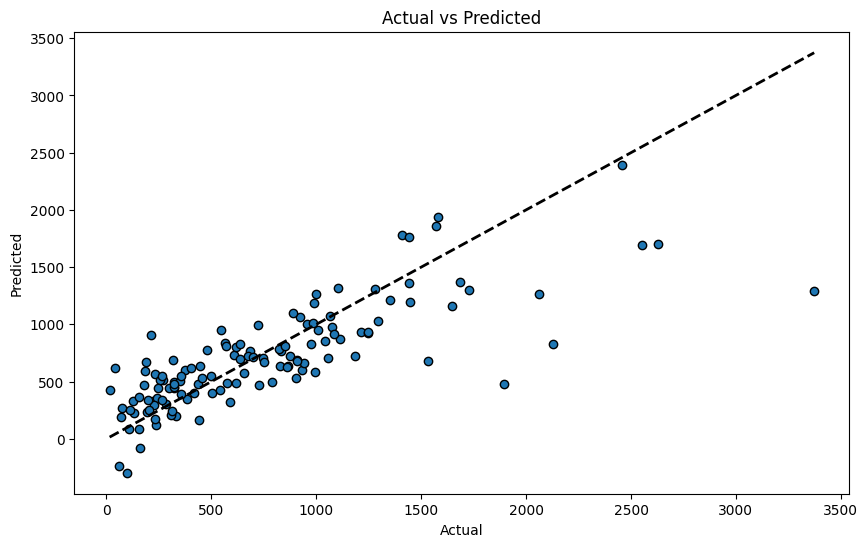

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

Let's go through the same steps as above except we are going to use a random forest regression instead of a linear regression. If the relationship between the X and Y values is not strictly linear, we can expect more appropriate scores from this model

As expected, we have a smaller MSE and a larger R-Squared value. As the MSE is significantly lower than the linear regression, this means that the misses using this algorithm are closer than the misses from the linear regression. Since the R-Squared value improved as well, we can note that 75% of the variance in our data can be explained by this forest.

In [22]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R-squared:", r2_rf)

Random Forest Mean Squared Error: 87226.31894330708
Random Forest R-squared: 0.7563933088775048


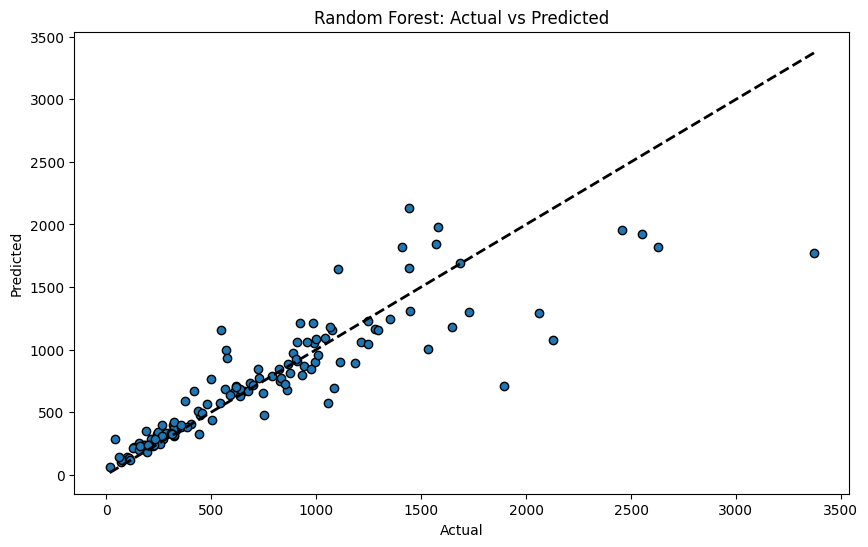

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

Now that we have a decent fit to our data, let's start looking to see how the bacon is made. We output each of our features and the importance value associated with each. The higher the importance, the more impactful this value is on our output.

In [24]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

Our pred_count value is the most important or most indicitive in our model. This is expected as the logic is explained above. A larger number of predatory fish in an ecosystem implies a healthy ecosystem compared to one with a low predator population.

In [25]:
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. feature pred_count (0.3830009522452817)
2. feature ABUND (0.31323790755158815)
3. feature RA (0.16414781428976122)
4. feature WS_AREA (0.023414603169441637)
5. feature LWSKM2 (0.022447674145632462)
6. feature LON_DD (0.012287840320676867)
7. feature ratio (0.00832476217291189)
8. feature tn (0.007916289792164341)
9. feature PHSTVL (0.007661913390279806)
10. feature LAT_DD (0.006916394838393362)
11. feature na (0.005135837590503732)
12. feature mg (0.004976445299387836)
13. feature NO3 (0.004781830699811778)
14. feature CL (0.004365805758115947)
15. feature alk (0.004195089171070555)
16. feature hco3 (0.003190997212178227)
17. feature SO4 (0.0029532640382720823)
18. feature COND (0.0028131373423795287)
19. feature k (0.0027132163547760007)
20. feature SO4HCO3 (0.0026071911973094106)
21. feature CA (0.0024554700270157425)
22. feature month (0.0024184923022045443)
23. feature YEAR (0.002414388192016522)
24. feature HUC (0.0021673996316282093)
25. feature lcond (0.00202

Graph it out

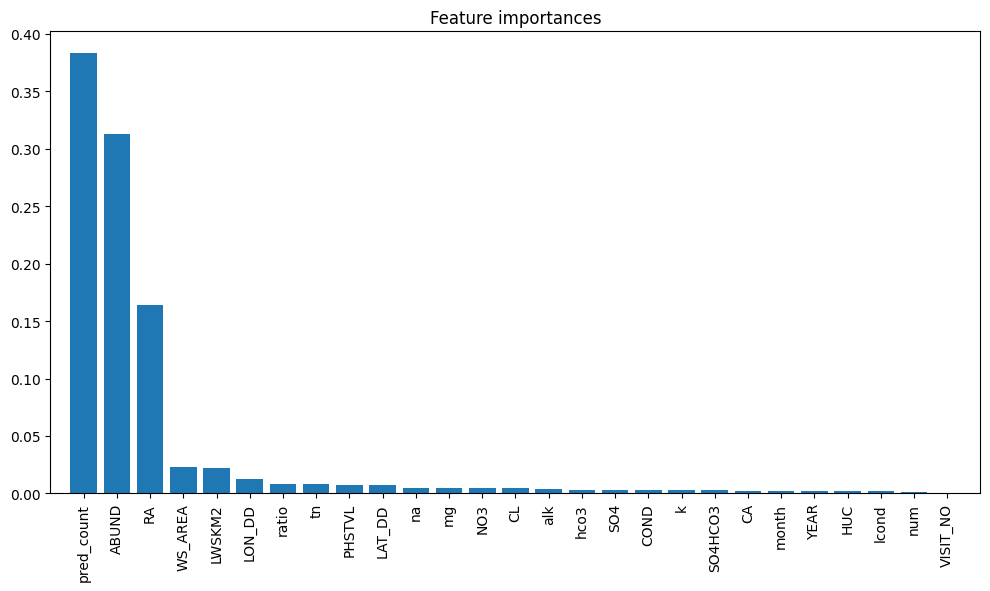

In [26]:
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

Please note the linearity of these points. This compliments our above domain assumption because it's showing a linear relationship between the total count of our minnow and the predator count

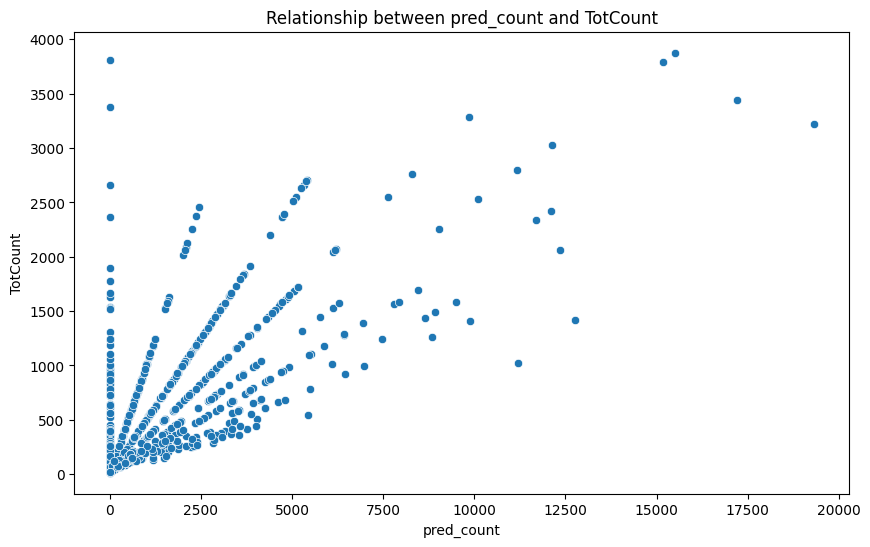

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fish_df['pred_count'], y=fish_df['TotCount'])
plt.xlabel('pred_count')
plt.ylabel('TotCount')
plt.title('Relationship between pred_count and TotCount')
plt.show()

Let's talk about the ABUND column. Per the column description file that came with the raw dataset, the ABUND column simply states the Abundance. It's unclear how TotCount is derived from ABUND if it is at all (I suspect so since there's a high impact from this value). Due to this ambiguity, we are going to try running the random forest regression again with the ABUND column removed to see how it impacts our findings.

In [28]:
X_no_abund = numerical_df.drop(columns=['TotCount', 'ABUND'])
y = numerical_df['TotCount']
X_train_no_abund, X_test_no_abund, y_train_no_abund, y_test_no_abund = train_test_split(X_no_abund, y, test_size=0.2, random_state=42)
X_train_no_abund_scaled = scaler.fit_transform(X_train_no_abund)
X_test_no_abund_scaled = scaler.transform(X_test_no_abund)
rf_model_no_abund = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_no_abund.fit(X_train_no_abund_scaled, y_train_no_abund)

RandomForestRegressor(random_state=42)

The scores are in and they are *significantly* worse. It looks like ABUND is a necessary input (at this point) for a model to have some reliability in it's predictions

In [29]:
y_pred_rf_no_abund = rf_model_no_abund.predict(X_test_no_abund_scaled)
mse_rf_no_abund = mean_squared_error(y_test_no_abund, y_pred_rf_no_abund)
r2_rf_no_abund = r2_score(y_test_no_abund, y_pred_rf_no_abund)

print("Random Forest without ABUND Mean Squared Error:", mse_rf_no_abund)
print("Random Forest without ABUND R-squared:", r2_rf_no_abund)

Random Forest without ABUND Mean Squared Error: 199423.78616771652
Random Forest without ABUND R-squared: 0.4430469006606508


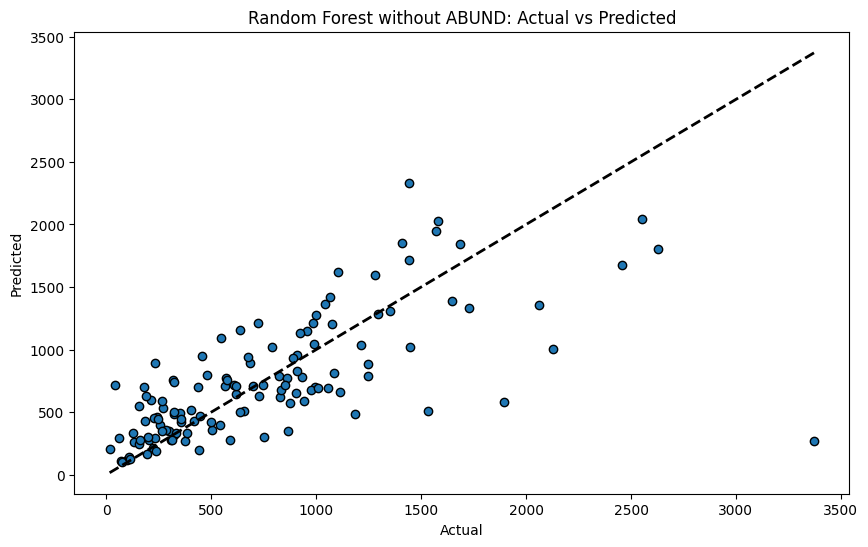

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_no_abund, y_pred_rf_no_abund, edgecolors=(0, 0, 0))
plt.plot([y_test_no_abund.min(), y_test_no_abund.max()], [y_test_no_abund.min(), y_test_no_abund.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest without ABUND: Actual vs Predicted')
plt.show()

Let's add in the abundance column and try to add in some polynomial features to see if they can help improve the model

In [34]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_poly_scaled, y_train)

Well, that didn't help at all. In fact, when compared to our initial random forest model, we see a slight degradation. This implies that the polynomial features introduced noise into our model, and it was potentially suffering from overfitting.

In [36]:
y_pred_rf = rf_model.predict(X_test_poly_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the results
print("Random Forest Mean Squared Error:", mse_rf)
print("Random Forest R-squared:", r2_rf)

Random Forest Mean Squared Error: 89283.85772362206
Random Forest R-squared: 0.7506469903328172
